# 強化学習
## RLパッケージ（cheinerRL）を使用してDQNを実装
- タスクはOpenAIGymのCartPole
- 連続状態、２行動の制御問題
***
Tetsuro Morimura, 2020

# 準備

### Colabランタイムの設定

- 始める前に，「ランタイム→ランタイムのタイプの変更」から，アクセラレーターをGPUに設定しておく

### 環境の設定

In [1]:
# chainer, cheinerRLのインストール
# 動画の保存に必要なモジュールのインストール
!curl https://colab.chainer.org/install | sh -!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null

!pip -q install chainerrl
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

sh: 0: Illegal option -!
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   9349      0 --:--:-- --:--:-- --:--:--  9349
(23) Failed writing body


In [2]:
!apt -q install python-opengl
!apt -q install ffmpeg
!apt -q install xvfb

Reading package lists...
Building dependency tree...
Reading state information...
python-opengl is already the newest version (3.1.0+dfsg-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove a

### モジュールのインポート

In [3]:
# essential models
import chainer
import chainer.functions as F
import chainer.links as L
import chainerrl
import gym
import numpy as np
from matplotlib import pyplot as plt

# modules for movie
from IPython import display as ipythondisplay
import glob
import io
import base64
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip install pyvirtualdisplay

from pyvirtualdisplay import Display
import os

/usr/local/lib/python3.7/dist-packages/chainer/_environment_check.py:75: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda101) version 9.1.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda101>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


# 環境の設定

### ゲーム環境の設定，確認
- 観測空間，アクションスペース

In [4]:
env = gym.make('CartPole-v0') ## ゲーム環境の設定（棒制御）

print('observation space:', env.observation_space) ## 観測空間のチェック
print('action space:', env.action_space) ## アクションスペースのチェック

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)


In [5]:
obs = env.reset() ## 観測値の初期化
#env.render() ## 学習過程のレンダリング関数
print('initial observation:', obs)

initial observation: [ 0.01378083 -0.04857511  0.0395901  -0.03677589]


In [6]:
action = env.action_space.sample() ## アクション結果の初期値
obs, r, done, info = env.step(action) ## 学習結果の出力

## 出力の確認
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

next observation: [ 0.01280933  0.1459574   0.03885458 -0.31670957]
reward: 1.0
done: False
info: {}


### 動画の記録、再生のための設定

- 動画関連のメソッドの定義

In [7]:
def wrap_env(env):
    # force=True：以前のモニタファイルを自動的にクリア
    env = gym.wrappers.Monitor(env, './video', force=True)
    return env

def show_video():
    mp4list = glob.glob('video/*.mp4')
    #print(len(mp4list))
    if len(mp4list) > 0:
        for m in range(len(mp4list)):
            mp4 = mp4list[m]
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            ipythondisplay.display(ipythondisplay.HTML(data='''
                <video alt="test" autoplay loop controls style="height: 300px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else: 
          print("Could not find video")

- ディスプレイの設定

In [8]:
display = Display(visible=0, size=(1024, 768))
display.start()

#os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

# エージェントの設定

### Q-Networkの構成

In [9]:
class Q_function(chainer.Chain):
  """
  Neural Network の定義
  3層のNN（隠れ層の層数のデフォルト値は50）
  """

  def __init__(self, obs_size, n_actions, n_hidden_channels=50):
    super().__init__()
    with self.init_scope():
      self.f_0 = L.Linear(obs_size, n_hidden_channels) ## 出力 = 観測データのサイズ × 隠れ層のチャンネル数　の行列
      self.f_1 = L.Linear(n_hidden_channels, n_hidden_channels) ## 出力 = 隠れ層のチャンネル数 × 隠れ層のチャンネル数　の行列
      self.f_2 = L.Linear(n_hidden_channels, n_actions) ## 出力 = 隠れ層のチャンネル数 × アクション数 のベクトル

  def __call__(self, x, test=False):
        """
        Args:
            x (ndarray or chainer.Variable): 観測値
            test (bool): テスト時か否かのフラグ
        """
        h = F.tanh(self.f_0(x)) ## 活性化関数は hyperbolic tangent function
        h = F.tanh(self.f_1(h))
        return chainerrl.action_value.DiscreteActionValue(self.f_2(h))

In [10]:
obs_size = env.observation_space.shape[0] ## 観測値のサイズ
n_actions = env.action_space.n ## アクションの種類数
q_func = Q_function(obs_size, n_actions) ## Q-Functonの定義

### GPUのための設定

In [11]:
q_func.to_gpu(0)

### オプティマイザの設定

In [18]:
optimizer = chainer.optimizers.Adam(alpha=0.001) ## Adamの使用，学習率を設定
optimizer.setup(q_func)

### DQNのエージェント設定

In [19]:
gamma = 0.98 ## discount factor値の設定：　報酬に対する罰則項

# epsilon-greedy 探索の使用
explorer = chainerrl.explorers.ConstantEpsilonGreedy(epsilon=0.3, random_action_func=env.action_space.sample)

# replay buffer と，そのキャパシティの特定
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity=10 ** 6)

# CartPole-v0から得られる観測値は，　numpy.float64の型で返されるが，　Chainerはnumpy.float32の型を想定している
# 型の変換関数を用意しておく
phi = lambda x: x.astype(np.float32, copy=False)

# 学習環境の設定
agent = chainerrl.agents.DoubleDQN(
    q_func, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=1,
    target_update_interval=100, phi=phi)

# 実験
### 実験条件の設定

In [20]:
n_episodes = 200 # エピソード数
#n_episodes = 400
#n_episodes = 600
#n_episodes = 1000

max_episode_len = 200 # 最大エピソード長

### 学習

In [21]:
return_list  = []

for i in range(1, n_episodes + 1):
    obs = env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done and t < max_episode_len:
        # Uncomment to watch the behaviour
        # env.render()
        action = agent.act_and_train(obs, reward)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
    if i % 10 == 0:
        print('episode:', i,
              'R:', R,
              'statistics:', agent.get_statistics())
    agent.stop_episode_and_train(obs, reward, done)
    # store return
    return_list.append(R)
print('Finished.')

episode: 10 R: 11.0 statistics: [('average_q', 0.15460780300518065), ('average_loss', 0), ('n_updates', 0)]
episode: 20 R: 10.0 statistics: [('average_q', 0.2761441129149081), ('average_loss', 0), ('n_updates', 0)]
episode: 30 R: 11.0 statistics: [('average_q', 0.40487547960442083), ('average_loss', 0), ('n_updates', 0)]
episode: 40 R: 10.0 statistics: [('average_q', 0.5275029863296867), ('average_loss', 0), ('n_updates', 0)]
episode: 50 R: 11.0 statistics: [('average_q', 0.6765984962548722), ('average_loss', 0.24216359775952123), ('n_updates', 46)]
episode: 60 R: 9.0 statistics: [('average_q', 0.8466862596907482), ('average_loss', 0.3015086946948869), ('n_updates', 155)]
episode: 70 R: 60.0 statistics: [('average_q', 1.5556931601396633), ('average_loss', 0.21296652742359762), ('n_updates', 382)]
episode: 80 R: 66.0 statistics: [('average_q', 3.4999091197761016), ('average_loss', 0.3449973236774002), ('n_updates', 794)]
episode: 90 R: 53.0 statistics: [('average_q', 6.974370303918235),

- 学習曲線

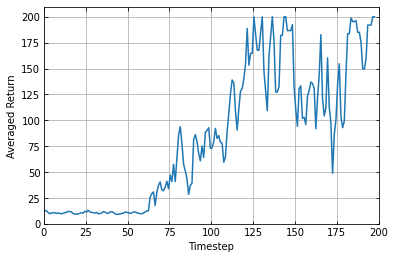

In [22]:
## Visualization
t_lim       = len(return_list)
window_size = 3

# smooth return
v = np.ones(window_size)/window_size
smoothed_return = np.convolve( return_list, v, mode='valid')

# plot
xlim = np.array(range(window_size-1,t_lim)) - window_size/2
plt.plot(xlim, smoothed_return)
plt.xlabel('Timestep')
plt.ylabel('Averaged Return')
plt.tick_params(top = True, right = True, direction = 'in')
plt.grid(which='both')
plt.xlim(0,t_lim)
plt.show()

### テスト

In [23]:
# エピソードを生成し、動画を保存
envw = wrap_env(gym.make('CartPole-v0'))

for i in range(2):
    obs = envw.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        envw.render()
        action = agent.act(obs)
        obs, r, done, _ = envw.step(action)
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
    agent.stop_episode()

envw.close()

# 動画の再生
show_video()

# Colab上から動画を削除
!rm video/openaigym.video.*

test episode: 0 R: 200.0
test episode: 1 R: 200.0
